In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
#from keras.utils.vis_utils import plot_model

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile
zf = ZipFile("/content/xyz.zip")
zf.extractall('/content')
zf.close()

In [ ]:
train_dir = '/content/images/train/'
test_dir = '/content/images/validation/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

<Axes: >

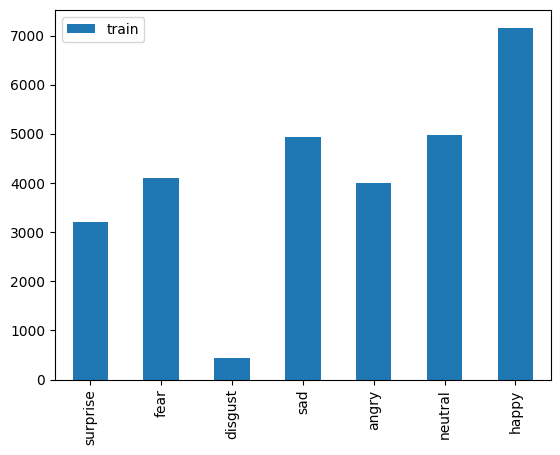

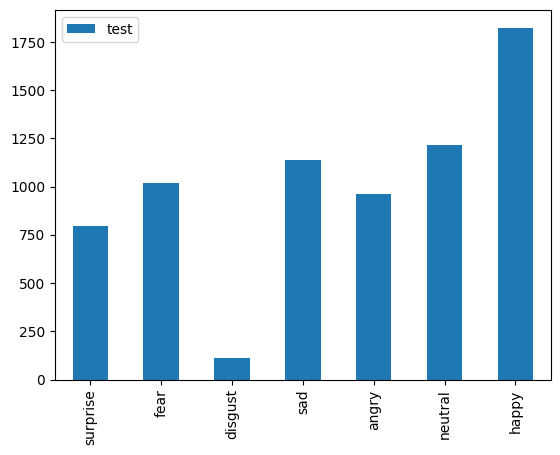

In [ ]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

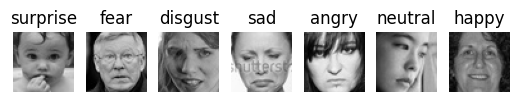

In [ ]:
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
class_labels = {'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
weight_decay = 1e-4

num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1088      
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        65600     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                       

In [ ]:
!pip install keras-utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=dce8e7abfe1fe9bb95e75cf3d1f2588aa2bfa29565bdd3d7d52526ee9755cae0
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=31,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/31
360/360 [==============================] - ETA: 0s - loss: 1.8067 - accuracy: 0.3243
Epoch 1: val_accuracy improved from -inf to 0.32413, saving model to model.weights.best.hdf5
360/360 [==============================] - 49s 78ms/step - loss: 1.8067 - accuracy: 0.3243 - val_loss: 1.8036 - val_accuracy: 0.3241
Epoch 2/31


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/360 [============================>.] - ETA: 0s - loss: 1.5526 - accuracy: 0.4154
Epoch 2: val_accuracy improved from 0.32413 to 0.45052, saving model to model.weights.best.hdf5
360/360 [==============================] - 21s 57ms/step - loss: 1.5520 - accuracy: 0.4158 - val_loss: 1.4811 - val_accuracy: 0.4505
Epoch 3/31
359/360 [============================>.] - ETA: 0s - loss: 1.4495 - accuracy: 0.4565
Epoch 3: val_accuracy improved from 0.45052 to 0.47795, saving model to model.weights.best.hdf5
360/360 [==============================] - 22s 60ms/step - loss: 1.4491 - accuracy: 0.4567 - val_loss: 1.3796 - val_accuracy: 0.4780
Epoch 4/31
360/360 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.4919
Epoch 4: val_accuracy improved from 0.47795 to 0.49774, saving model to model.weights.best.hdf5
360/360 [==============================] - 22s 61ms/step - loss: 1.3650 - accuracy: 0.4919 - val_loss: 1.3318 - val_accuracy: 0.4977
Epoch 5/31
359/360 [================

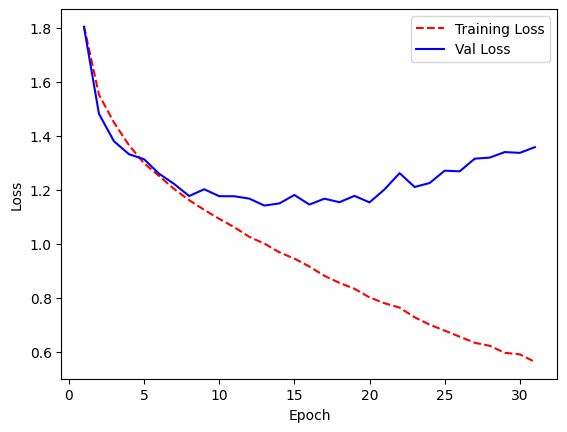

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

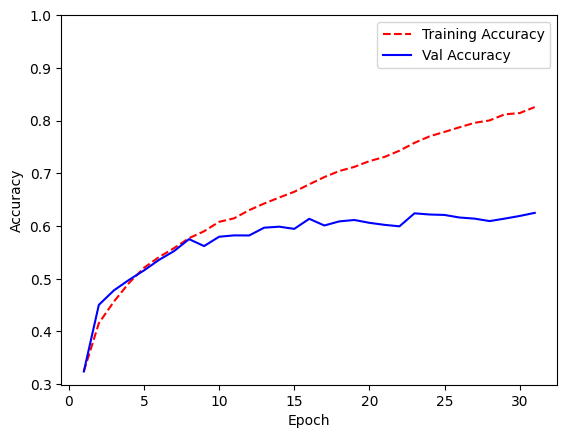

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [ ]:
# saving the model
model.save("fer_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

110/110 [==============================] - 3s 29ms/step - loss: 1.3232 - accuracy: 0.6270
Test accuracy = 62.69886493682861%


In [ ]:
x_test,y_test = next(test_set)
predict = model.predict(x_test)

2/2 [==============================] - 0s 7ms/step
